<a href="https://colab.research.google.com/github/rakshithcgowda/Human_AI/blob/master/Text_recognition_with_transformer_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y poppler-utils


In [ ]:
!pip install pdf2image

In [ ]:
!pip install docx

In [ ]:
# rm -rf /content/jpg_images

#Convert form PDF to JPG

In [ ]:
import os
from PIL import Image
from pdf2image import convert_from_path, pdfinfo_from_path

def convert_pdf_to_jpg(pdf_dir, jpg_dir, dpi=200):
    """
    Convert PDF files to JPG images. Each page of a PDF will be converted to a separate JPG image.

    This version processes one page at a time, which can help reduce memory usage.

    Args:
        pdf_dir (str): Directory containing PDF files.
        jpg_dir (str): Directory where the JPG images will be saved.
        dpi (int): Resolution for converting PDF pages.
    """
    if not os.path.exists(jpg_dir):
        os.makedirs(jpg_dir)

    for filename in os.listdir(pdf_dir):
        if filename.lower().endswith(".pdf"):
            pdf_path = os.path.join(pdf_dir, filename)
            try:
                # Retrieve PDF information to get the total number of pages.
                info = pdfinfo_from_path(pdf_path, userpw=None)
                total_pages = info.get("Pages", 0)
                print(f"Processing '{filename}' with {total_pages} pages.")

                # Process each page individually to reduce memory usage.
                for page_number in range(1, total_pages + 1):
                    # Convert only one page at a time.
                    pages = convert_from_path(
                        pdf_path, dpi=dpi, first_page=page_number, last_page=page_number
                    )
                    for page in pages:
                        jpg_filename = os.path.splitext(filename)[0] + f"_page{page_number}.jpg"
                        jpg_path = os.path.join(jpg_dir, jpg_filename)
                        page.save(jpg_path, "JPEG")
                        print(f"Saved JPG image to {jpg_path}")
            except Exception as e:
                print(f"Failed to process {pdf_path}: {e}")

if __name__ == "__main__":
    # Directories for PDF and JPG images.
    pdf_folder = "/content/pdf"          # Directory with your PDF files
    jpg_folder = "/content/jpg_images"     # Directory to save JPG images after conversion from PDF

    # Convert PDF files to JPG images.
    convert_pdf_to_jpg(pdf_folder, jpg_folder, dpi=200)


##Convert JPG to Mask images

In [ ]:
import os
from PIL import Image

def convert_jpgs_to_mask(jpg_dir, mask_dir, threshold=128):
    """
    Convert JPG images to binary mask images using a simple threshold.

    Args:
        jpg_dir (str): Directory containing JPG images.
        mask_dir (str): Directory where mask images will be saved.
        threshold (int): Grayscale threshold value (0-255) to determine mask cutoff.
                         Pixels with values above this threshold will be white (255),
                         otherwise black (0).
    """
    if not os.path.exists(mask_dir):
        os.makedirs(mask_dir)

    for filename in os.listdir(jpg_dir):
        if filename.lower().endswith(".jpg"):
            jpg_path = os.path.join(jpg_dir, filename)
            try:
                # Open the image and convert it to grayscale.
                img = Image.open(jpg_path)
                img_gray = img.convert("L")

                # Apply threshold to create a binary mask.
                mask = img_gray.point(lambda p: 255 if p > threshold else 0)

                # Save the mask image with a new name.
                mask_filename = os.path.splitext(filename)[0] + "_mask.png"
                mask_path = os.path.join(mask_dir, mask_filename)
                mask.save(mask_path)
                print(f"Saved mask image to {mask_path}")
            except Exception as e:
                print(f"Failed to process {jpg_path}: {e}")

# -------------------------
# Example usage:
# -------------------------
if __name__ == "__main__":
    jpg_folder = "/content/jpg_images"      # Directory with your existing JPG images
    mask_output_folder = "/content/mask_imgs" # Directory to save the generated mask images
    convert_jpgs_to_mask(jpg_folder, mask_output_folder, threshold=128)


##Specific Task I - Layout Organization Recognition:

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image

###########################################
# Note on Image Quality and OCR
###########################################
# If you use this model (or a similar one) for text segmentation/OCR tasks,
# be aware that low resolution, blurriness, poor contrast, and other image artifacts
# can lead to poor predictions. To help improve performance, consider:
#   - Using high-resolution images
#   - Ensuring proper lighting and contrast
#   - Cropping out extraneous background or noise
#
# The mismatch between input clarity and predicted output is often due to these factors.

###########################################
# Dataset Class
###########################################
class LayoutDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = sorted([f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_filename = self.images[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        mask_filename = f"{os.path.splitext(img_filename)[0]}_mask.png"
        mask_path = os.path.join(self.mask_dir, mask_filename)

        image = Image.open(img_path).convert("RGB")
        if os.path.exists(mask_path):
            mask = Image.open(mask_path).convert("L")
        else:
            print(f"Warning: Missing mask for {img_filename}. Using blank mask.")
            mask = Image.new("L", image.size, 0)

        image = self.image_transform(image) if self.image_transform else transforms.ToTensor()(image)
        mask = self.mask_transform(mask) if self.mask_transform else transforms.ToTensor()(mask)
        # Convert mask to binary (0 and 1)
        mask = (mask > 0.5).long().squeeze(0)
        return image, mask

###########################################
# Building Blocks for Advanced Model
###########################################
# Residual Double Convolution Block
class ResDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResDoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU(inplace=True)
        # Adjust dimensions if needed
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x if self.res_conv is None else self.res_conv(x)
        out = self.double_conv(x)
        out += residual
        return self.relu(out)

# Attention Block for Skip Connections
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# Up Block with Attention on Skip Connections
class UpAttention(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        """
        in_channels: number of channels from concatenated decoder and encoder features.
        out_channels: desired number of output channels.
        """
        super(UpAttention, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        # For the attention gate, assume both the upsampled feature and skip connection have half of in_channels each.
        self.attention = AttentionBlock(F_g=in_channels // 2, F_l=in_channels // 2, F_int=in_channels // 4)
        # After concatenation of features, use a residual double conv block.
        self.conv = ResDoubleConv(in_channels, out_channels)

    def forward(self, x_up, x_skip):
        x_up = self.up(x_up)
        # Ensure sizes match by padding if necessary.
        diffY = x_skip.size()[2] - x_up.size()[2]
        diffX = x_skip.size()[3] - x_up.size()[3]
        x_up = F.pad(x_up, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])
        # Refine the skip connection with attention.
        x_skip = self.attention(g=x_up, x=x_skip)
        # Concatenate along the channel dimension.
        x = torch.cat([x_skip, x_up], dim=1)
        return self.conv(x)

# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # [max_len, 1, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [seq_len, batch_size, d_model]
        seq_len = x.size(0)
        return x + self.pe[:seq_len]

###########################################
# AdvancedTransUNet: Refined Architecture
###########################################
class AdvancedTransUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True, transformer_layers=2, nhead=8):
        super(AdvancedTransUNet, self).__init__()
        # Encoder with residual blocks
        self.inc = ResDoubleConv(n_channels, 64)         # [B, 64, H, W]
        self.down1 = nn.Sequential(nn.MaxPool2d(2), ResDoubleConv(64, 128))   # [B, 128, H/2, W/2]
        self.down2 = nn.Sequential(nn.MaxPool2d(2), ResDoubleConv(128, 256))  # [B, 256, H/4, W/4]
        self.down3 = nn.Sequential(nn.MaxPool2d(2), ResDoubleConv(256, 512))  # [B, 512, H/8, W/8]
        factor = 2 if bilinear else 1
        self.down4 = nn.Sequential(nn.MaxPool2d(2), ResDoubleConv(512, 1024 // factor))  # [B, 1024//factor, H/16, W/16]

        self.feature_dim = 1024 // factor  # Bottleneck channels

        # Projection layer (if needed) and positional encoding before transformer
        self.transformer_input_proj = nn.Conv2d(self.feature_dim, self.feature_dim, kernel_size=1)
        self.pos_encoder = PositionalEncoding(d_model=self.feature_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.feature_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=transformer_layers)

        # Decoder with Attention-based Up Blocks
        # Note: in_channels here is the sum of channels from upsampled feature and corresponding encoder skip.
        self.up1 = UpAttention(in_channels=1024, out_channels=256, bilinear=bilinear)  # x5 (512) + x4 (512) = 1024 -> 256
        self.up2 = UpAttention(in_channels=512, out_channels=128, bilinear=bilinear)   # 256 + 256 = 512 -> 128
        self.up3 = UpAttention(in_channels=256, out_channels=64, bilinear=bilinear)    # 128 + 128 = 256 -> 64
        self.up4 = UpAttention(in_channels=128, out_channels=64, bilinear=bilinear)    # 64 + 64 = 128 -> 64

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)       # [B, 64, H, W]
        x2 = self.down1(x1)    # [B, 128, H/2, W/2]
        x3 = self.down2(x2)    # [B, 256, H/4, W/4]
        x4 = self.down3(x3)    # [B, 512, H/8, W/8]
        x5 = self.down4(x4)    # [B, feature_dim, H/16, W/16]

        # Bottleneck with transformer
        x5 = self.transformer_input_proj(x5)
        B, C, H, W = x5.shape
        x5_flat = x5.view(B, C, H * W).permute(2, 0, 1)  # [seq_len, B, C]
        x5_flat = self.pos_encoder(x5_flat)
        x5_trans = self.transformer(x5_flat)
        x5 = x5_trans.permute(1, 2, 0).view(B, C, H, W)

        # Decoder with attention-enhanced skip connections
        x = self.up1(x5, x4)   # Combines bottleneck and encoder feature x4
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)

###########################################
# Evaluation Metrics: IoU and Dice Coefficient
###########################################
def compute_iou(pred, target, smooth=1e-6):
    intersection = (pred & target).float().sum((1, 2))
    union = (pred | target).float().sum((1, 2))
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()

def compute_dice(pred, target, smooth=1e-6):
    intersection = (pred * target).float().sum((1, 2))
    dice = (2 * intersection + smooth) / (pred.float().sum((1, 2)) + target.float().sum((1, 2)) + smooth)
    return dice.mean().item()

###########################################
# Training and Evaluation Functions
###########################################
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)  # [B, n_classes, H, W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_iou = 0
    total_dice = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            total_iou += compute_iou(preds, masks)
            total_dice += compute_dice(preds, masks)
    return total_iou / len(loader), total_dice / len(loader)

###########################################
# Main Training Routine
###########################################
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    img_dir = "/content/jpg_images"  # Folder with JPG images
    mask_dir = "/content/mask_imgs"  # Folder with corresponding _mask.png files

    # Define transforms: resize images and masks to 256x256
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    dataset = LayoutDataset(img_dir, mask_dir, image_transform=transform, mask_transform=transform)
    train_len = int(0.8 * len(dataset))
    train_set, val_set = random_split(dataset, [train_len, len(dataset) - train_len])
    train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=4, shuffle=False)

    # Create the advanced model
    model = AdvancedTransUNet(n_channels=3, n_classes=2, bilinear=True, transformer_layers=2, nhead=8).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    num_epochs = 5
    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        iou, dice = evaluate(model, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs} - Loss: {train_loss:.4f} - Val IoU: {iou:.4f} - Val Dice: {dice:.4f}")

    torch.save(model.state_dict(), "advanced_transunet_model.pth")
    print("Training complete. Model saved as 'advanced_transunet_model.pth'.")

if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (94080000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/5 - Loss: 0.2443 - Val IoU: 0.9144 - Val Dice: 0.9546
Epoch 2/5 - Loss: 0.0934 - Val IoU: 0.9150 - Val Dice: 0.9549
Epoch 3/5 - Loss: 0.1003 - Val IoU: 0.9532 - Val Dice: 0.9759
Epoch 4/5 - Loss: 0.1296 - Val IoU: 0.9584 - Val Dice: 0.9787
Epoch 5/5 - Loss: 0.0829 - Val IoU: 0.9831 - Val Dice: 0.9915
Training complete. Model saved as 'advanced_transunet_model.pth'.


##STEP 2

In [ ]:
!pip install python-docx

excel file


In [ ]:
# rm -rf /content/ocr_images

##Converting a Word Document to OCR Images and Labels

In [ ]:
!pip install python-docx

In [ ]:
import os
from docx import Document
from PIL import Image, ImageDraw, ImageFont

def convert_multiple_docs_to_ocr(docx_dir, output_image_dir, output_text_dir):
    """
    Extracts text from multiple Word documents, processes each page separately,
    and saves the output as text files and images.

    Parameters:
      docx_dir (str): Directory containing Word (.docx) files.
      output_image_dir (str): Directory to save the rendered images.
      output_text_dir (str): Directory to save the extracted text files.
    """
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_text_dir, exist_ok=True)

    # Iterate through all .docx files in the directory
    for file in os.listdir(docx_dir):
        if file.endswith(".docx"):
            word_path = os.path.join(docx_dir, file)
            doc = Document(word_path)
            base_filename = os.path.splitext(file)[0]

            for i, para in enumerate(doc.paragraphs):
                page_text = para.text.strip()
                if not page_text:
                    continue  # Skip empty pages

                # Save extracted text
                text_filename = f"{base_filename}_page_{i+1}.txt"
                text_path = os.path.join(output_text_dir, text_filename)
                with open(text_path, 'w', encoding='utf-8') as f:
                    f.write(page_text)

                # Render text to image
                font = ImageFont.load_default()
                lines = page_text.splitlines() or [" "]
                line_height = font.getbbox('A')[3] - font.getbbox('A')[1] + 2
                max_line_width = max([font.getbbox(line)[2] - font.getbbox(line)[0] for line in lines])
                img_width = max_line_width + 20
                img_height = line_height * len(lines) + 20
                image = Image.new('L', (img_width, img_height), color=255)
                draw = ImageDraw.Draw(image)

                y_text = 10
                for line in lines:
                    draw.text((10, y_text), line, fill=0, font=font)
                    y_text += line_height

                # Save image
                image_filename = f"{base_filename}_page_{i+1}.jpg"
                image_path = os.path.join(output_image_dir, image_filename)
                image.save(image_path)

                print(f"Processed {file}, Page {i+1}: Saved text to {text_path} and image to {image_path}.")

# Example usage:
docx_directory = "/content/word"
image_output_directory = "ocr_images"
text_output_directory = "ocr_texts"
convert_multiple_docs_to_ocr(docx_directory, image_output_directory, text_output_directory)


##Specific Task II - Optical Character Recognition (OCR):


Found image files: ['Buendia transcription_page_1.jpg', 'Buendia transcription_page_10.jpg', 'Buendia transcription_page_2.jpg', 'Buendia transcription_page_3.jpg', 'Buendia transcription_page_4.jpg', 'Buendia transcription_page_5.jpg', 'Buendia transcription_page_6.jpg', 'Buendia transcription_page_7.jpg', 'Buendia transcription_page_8.jpg', 'Buendia transcription_page_9.jpg', 'Constituciones sinodales transcription_page_1.jpg', 'Constituciones sinodales transcription_page_10.jpg', 'Constituciones sinodales transcription_page_11.jpg', 'Constituciones sinodales transcription_page_2.jpg', 'Constituciones sinodales transcription_page_3.jpg', 'Constituciones sinodales transcription_page_4.jpg', 'Constituciones sinodales transcription_page_5.jpg', 'Constituciones sinodales transcription_page_6.jpg', 'Constituciones sinodales transcription_page_7.jpg', 'Constituciones sinodales transcription_page_8.jpg', 'Constituciones sinodales transcription_page_9.jpg', 'Ezcaray transcription_page_1.jpg'

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/110], Batch [10/35], Loss: 1.3198
Epoch [1/110], Batch [20/35], Loss: 2.1669
Epoch [1/110], Batch [30/35], Loss: 1.9043
Epoch [1/110] Average Loss: 1.6545

Epoch [2/110], Batch [10/35], Loss: 2.3591
Epoch [2/110], Batch [20/35], Loss: 2.3572
Epoch [2/110], Batch [30/35], Loss: 2.7690
Epoch [2/110] Average Loss: 2.6703

Epoch [3/110], Batch [10/35], Loss: 3.1347
Epoch [3/110], Batch [20/35], Loss: 2.6242
Epoch [3/110], Batch [30/35], Loss: 2.4918
Epoch [3/110] Average Loss: 2.8682

Epoch [4/110], Batch [10/35], Loss: 2.7173
Epoch [4/110], Batch [20/35], Loss: 2.2975
Epoch [4/110], Batch [30/35], Loss: 3.2894
Epoch [4/110] Average Loss: 2.8725

Epoch [5/110], Batch [10/35], Loss: 2.8424
Epoch [5/110], Batch [20/35], Loss: 2.2399
Epoch [5/110], Batch [30/35], Loss: 4.6711
Epoch [5/110] Average Loss: 2.7405

Epoch [6/110], Batch [10/35], Loss: 4.0364
Epoch [6/110], Batch [20/35], Loss: 2.4451
Epoch [6/110], Batch [30/35], Loss: 2.8147
Epoch [6/110] Average Loss: 2.3898

Epoch [7/1

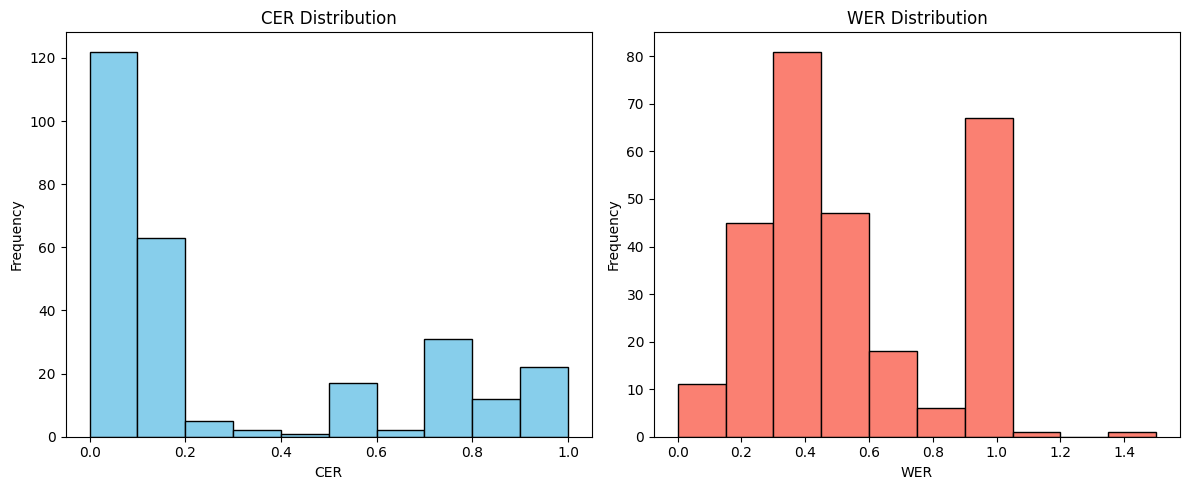

In [24]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import editdistance  # pip install editdistance
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# ----- Character Set & Label Conversion Utilities -----
# We use a character set covering lowercase letters (with accented characters) and digits.
# (Note: In this version we include a space token as the last character.)
CHAR_SET = "abcdefghijklmnopqrstuvwxyzáéíóúüñ0123456789,.?`~ "
# For CTC, index 0 is reserved for the blank token.
char_to_idx = {char: idx + 1 for idx, char in enumerate(CHAR_SET)}
idx_to_char = {idx + 1: char for idx, char in enumerate(CHAR_SET)}

def text_to_labels(text):
    """Convert a string to a list of label indices."""
    return [char_to_idx[char] for char in text.lower() if char in char_to_idx]

def labels_to_text(labels):
    """Convert a list of label indices to a string."""
    return "".join([idx_to_char[label] for label in labels if label in idx_to_char])

# ----- Custom Dataset -----
class OCRDataset(data.Dataset):
    def __init__(self, image_dir, text_dir, transform=None):
        """
        Args:
            image_dir (str): Directory containing OCR images (.jpg).
            text_dir (str): Directory containing corresponding text files (.txt).
            transform: Optional torchvision transforms to apply.
        """
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.transform = transform

        # List image and text files (case-insensitive).
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')])
        self.text_files = sorted([f for f in os.listdir(text_dir) if f.lower().endswith('.txt')])

        print("Found image files:", self.image_files)
        print("Found text files:", self.text_files)

        if len(self.image_files) == 0 or len(self.text_files) == 0:
            raise ValueError("No files found in the given directories.")
        assert len(self.image_files) == len(self.text_files), "Mismatch between images and text files."

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and convert to grayscale.
        img_file = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_file)
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        # Load the corresponding ground truth text.
        text_file = self.text_files[idx]
        text_path = os.path.join(self.text_dir, text_file)
        with open(text_path, 'r', encoding='utf-8') as f:
            gt_text = f.read().strip()
        label = torch.tensor(text_to_labels(gt_text), dtype=torch.long)

        return image, gt_text, label, len(label), img_file

# ----- Hybrid CNN + Transformer Model -----
class HybridOCRTransformer(nn.Module):
    def __init__(self, num_classes):
        """
        A hybrid model using a CNN backbone to extract spatial features followed by a Transformer encoder
        to model the sequence. This architecture is inspired by recent research on transformer-based OCR
        for historical texts.
        Expects input images of shape (batch, 1, 32, 128).

        Args:
            num_classes (int): Number of output classes (len(CHAR_SET) + 1 for blank).
        """
        super(HybridOCRTransformer, self).__init__()
        # CNN Backbone: extract spatial features
        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # (32,128) -> (32,128)
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                         # (32,128) -> (16,64)
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (16,64) -> (16,64)
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                         # (16,64) -> (8,32)
            nn.Conv2d(128, 256, kernel_size=3, padding=1),# (8,32) -> (8,32)
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)                          # (8,32) -> (4,16)
        )
        # After the CNN, feature map shape: (batch, 256, 4, 16)
        # Flatten spatial dimensions to obtain a sequence of length 4*16 = 64, with feature dimension 256.
        self.sequence_length = 4 * 16  # 64

        # Transformer Encoder for sequence modeling.
        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        # Final classification layer on each time step.
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # x: (batch, 1, 32, 128)
        features = self.cnn_backbone(x)  # -> (batch, 256, 4, 16)
        batch, C, H, W = features.size()
        # Flatten spatial dimensions: create sequence of shape (batch, H*W, C)
        features = features.view(batch, C, H * W).permute(0, 2, 1)  # (batch, 64, 256)
        # Transformer expects (sequence_length, batch, d_model)
        features = features.permute(1, 0, 2)  # (64, batch, 256)
        encoded = self.transformer_encoder(features)  # (64, batch, 256)
        encoded = encoded.permute(1, 0, 2)  # (batch, 64, 256)
        logits = self.fc(encoded)  # (batch, 64, num_classes)
        return logits

# ----- Greedy Decoder for CTC Outputs -----
def greedy_decoder(output, blank=0):
    """
    Decodes the raw output logits of shape (T, B, num_classes)
    into predicted text strings for each batch element.
    """
    # Compute argmax over classes at each time step.
    arg_maxes = torch.argmax(output, dim=2)  # (T, B)
    decoded_preds = []
    for args in arg_maxes.transpose(0, 1):  # iterate over batch
        pred = []
        prev = blank
        for idx in args:
            idx = idx.item()
            if idx != prev and idx != blank:
                pred.append(idx)
            prev = idx
        decoded_preds.append(labels_to_text(pred))
    return decoded_preds

# ----- Collate Function for DataLoader -----
def ocr_collate_fn(batch):
    images, texts, labels, label_lengths, filenames = zip(*batch)
    images = torch.stack(images, 0)
    label_lengths = torch.tensor(label_lengths, dtype=torch.long)
    labels_concat = torch.cat(labels)
    return images, texts, labels_concat, label_lengths, filenames

# ----- Evaluation Function for CER, WER and BLEU -----
def evaluate_samples_and_plot(model, eval_loader, device):
    """
    Evaluates the OCR model on individual samples, computing the Character Error Rate (CER),
    Word Error Rate (WER) and BLEU score for each sample, then plots the distribution of CER and WER.
    """
    model.eval()
    cer_list = []
    wer_list = []
    bleu_list = []
    smoothing = SmoothingFunction().method1  # Smoothing function for BLEU

    with torch.no_grad():
        for images, texts, _, _, _ in eval_loader:
            images = images.to(device)
            outputs = model(images)  # (batch, sequence, num_classes)
            outputs = outputs.permute(1, 0, 2)  # (sequence, batch, num_classes)
            preds = greedy_decoder(outputs)
            pred = preds[0]
            gt_text = texts[0]
            # Compute CER: edit distance normalized by length of ground truth.
            cer = editdistance.eval(pred, gt_text) / len(gt_text) if len(gt_text) > 0 else 0
            # Compute WER: tokenize texts by space and compute edit distance.
            pred_words = pred.split()
            gt_words = gt_text.split()
            wer = editdistance.eval(pred_words, gt_words) / len(gt_words) if len(gt_words) > 0 else 0
            # Compute BLEU score (using tokenized words).
            # Using a list of reference tokens and candidate tokens.
            bleu = sentence_bleu([gt_words], pred_words, smoothing_function=smoothing)

            cer_list.append(cer)
            wer_list.append(wer)
            bleu_list.append(bleu)

            # Print predicted and ground truth texts along with their metrics.
            print(f"Ground Truth: {gt_text}")
            print(f"Predicted   : {pred}")
            print(f"CER: {cer:.3f}, WER: {wer:.3f}, BLEU: {bleu:.3f}\n")

    avg_cer = sum(cer_list) / len(cer_list)
    avg_wer = sum(wer_list) / len(wer_list)
    avg_bleu = sum(bleu_list) / len(bleu_list)
    print(f"Average CER: {avg_cer:.3f}")
    print(f"Average WER: {avg_wer:.3f}")
    print(f"Average BLEU: {avg_bleu:.3f}")

    # Plot histogram of CER and WER
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(cer_list, bins=10, color="skyblue", edgecolor="black")
    plt.title("CER Distribution")
    plt.xlabel("CER")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(wer_list, bins=10, color="salmon", edgecolor="black")
    plt.title("WER Distribution")
    plt.xlabel("WER")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# ----- Main Training and Evaluation Routine -----
def train_and_evaluate(image_dir, text_dir, img_height=32, img_width=128,
                       num_epochs=110, batch_size=8, learning_rate=0.0005):
    """
    This routine trains the hybrid CNN+Transformer model using CTC loss.
    After training, it computes the character error rate (CER), word error rate (WER),
    and BLEU score for each sample and then plots the results.
    """
    transform = transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),  # scales pixel values to [0,1]
    ])

    dataset = OCRDataset(image_dir, text_dir, transform=transform)
    train_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=ocr_collate_fn)

    num_classes = len(CHAR_SET) + 1  # +1 for the blank token
    model = HybridOCRTransformer(num_classes=num_classes)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # CTC Loss expects raw logits.
    ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting training of the hybrid CNN+Transformer model...")
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_idx, (images, _, labels, label_lengths, _) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)  # (batch, sequence, num_classes)
            outputs = outputs.permute(1, 0, 2)  # (sequence, batch, num_classes)
            batch_size_actual = images.size(0)
            input_lengths = torch.full(size=(batch_size_actual,), fill_value=outputs.size(0), dtype=torch.long)

            loss = ctc_loss(outputs, labels, input_lengths, label_lengths)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss/len(train_loader):.4f}\n")

    torch.save(model.state_dict(), "hybrid_ocr_transformer.pth")
    print("Training complete and model saved as 'hybrid_ocr_transformer.pth'.\n")

    # Evaluate the model on individual samples using CER, WER and BLEU, then plot results.
    eval_loader = data.DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=ocr_collate_fn)
    print("Evaluating model on individual samples (CER, WER & BLEU):")
    evaluate_samples_and_plot(model, eval_loader, device)

# ----- Example Usage -----
if __name__ == "__main__":
    # Set these directories to point to your OCR images (JPG) and ground truth texts (TXT).
    image_directory = "/content/ocr_images"  # Directory containing .jpg files.
    text_directory = "/content/ocr_texts"      # Directory containing corresponding .txt files.

    # Adjust hyperparameters as needed. Here we use 100 epochs for demonstration.
    train_and_evaluate(image_directory, text_directory, img_height=32, img_width=128,
                       num_epochs=110, batch_size=8, learning_rate=0.0005)


In [ ]:
!pip install streamlit pyngrok


##Steamlit Code

In [8]:
!pkill ngrok

##Specific Task I

In [9]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import os

###########################################
# Utility Function: Convert Image to Mask
###########################################
def convert_to_mask(image, threshold=128):
    """
    Convert a PIL image to a binary mask using a grayscale threshold.
    Pixels with values above the threshold become 255 (white),
    otherwise 0 (black).
    """
    img_gray = image.convert("L")
    mask = img_gray.point(lambda p: 255 if p > threshold else 0)
    return mask

###########################################
# Model Building Blocks (matching training code)
###########################################
# Residual Double Convolution Block
class ResDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResDoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU(inplace=True)
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x if self.res_conv is None else self.res_conv(x)
        out = self.double_conv(x)
        out += residual
        return self.relu(out)

# Attention Block for Skip Connections
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# Up Block with Attention-Based Skip Connections
class UpAttention(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(UpAttention, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.attention = AttentionBlock(F_g=in_channels // 2, F_l=in_channels // 2, F_int=in_channels // 4)
        self.conv = ResDoubleConv(in_channels, out_channels)

    def forward(self, x_up, x_skip):
        x_up = self.up(x_up)
        diffY = x_skip.size()[2] - x_up.size()[2]
        diffX = x_skip.size()[3] - x_up.size()[3]
        x_up = F.pad(x_up, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])
        x_skip = self.attention(g=x_up, x=x_skip)
        x = torch.cat([x_skip, x_up], dim=1)
        return self.conv(x)

# Positional Encoding for the Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # shape: (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(0)
        return x + self.pe[:seq_len]

###########################################
# AdvancedTransUNet: Architecture (matching training code)
###########################################
class AdvancedTransUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True, transformer_layers=2, nhead=8):
        super(AdvancedTransUNet, self).__init__()
        # Encoder
        self.inc = ResDoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), ResDoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), ResDoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), ResDoubleConv(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = nn.Sequential(nn.MaxPool2d(2), ResDoubleConv(512, 1024 // factor))
        self.feature_dim = 1024 // factor

        # Transformer Bottleneck
        self.transformer_input_proj = nn.Conv2d(self.feature_dim, self.feature_dim, kernel_size=1)
        self.pos_encoder = PositionalEncoding(d_model=self.feature_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.feature_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=transformer_layers)

        # Decoder
        self.up1 = UpAttention(in_channels=1024, out_channels=256, bilinear=bilinear)
        self.up2 = UpAttention(in_channels=512, out_channels=128, bilinear=bilinear)
        self.up3 = UpAttention(in_channels=256, out_channels=64, bilinear=bilinear)
        self.up4 = UpAttention(in_channels=128, out_channels=64, bilinear=bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)       # [B, 64, H, W]
        x2 = self.down1(x1)    # [B, 128, H/2, W/2]
        x3 = self.down2(x2)    # [B, 256, H/4, W/4]
        x4 = self.down3(x3)    # [B, 512, H/8, W/8]
        x5 = self.down4(x4)    # [B, feature_dim, H/16, W/16]

        # Transformer Bottleneck
        x5 = self.transformer_input_proj(x5)
        B, C, H, W = x5.shape
        x5_flat = x5.view(B, C, H * W).permute(2, 0, 1)  # [seq_len, B, C]
        x5_flat = self.pos_encoder(x5_flat)
        x5_trans = self.transformer(x5_flat)
        x5 = x5_trans.permute(1, 2, 0).view(B, C, H, W)

        # Decoder
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)

###########################################
# Streamlit App
###########################################
st.title("Advanced TransUNet Layout Segmentation")
st.write("Upload a JPG, PNG, or JPRG image. The image will be converted to a binary mask and processed for segmentation.")

# Allow only jpg, png, or jprg files.
uploaded_file = st.file_uploader("Choose an image file", type=["jpg", "jpeg", "png", "jprg"])

if uploaded_file is not None:
    # Open the image and display the original.
    image = Image.open(uploaded_file).convert("RGB")
    st.subheader("Original Image")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Convert the image to a binary mask.
    mask_image = convert_to_mask(image, threshold=128)
    st.subheader("Converted Binary Mask")
    st.image(mask_image, caption="Binary Mask (Threshold = 128)", use_column_width=True)

    # Preprocess the original image for the model (resize to 256x256 and convert to tensor).
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    image_tensor = transform(image).unsqueeze(0)  # Shape: (1, 3, 256, 256)

    # Load the pretrained AdvancedTransUNet model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AdvancedTransUNet(n_channels=3, n_classes=2, bilinear=True, transformer_layers=2, nhead=8).to(device)

    try:
        model.load_state_dict(torch.load("advanced_transunet_model.pth", map_location=device))
        model.eval()
    except Exception as e:
        st.error(f"Failed to load model: {e}")

    # Run the prediction.
    with torch.no_grad():
        outputs = model(image_tensor.to(device))  # Output shape: [1, 2, 256, 256]
        preds = torch.argmax(outputs, dim=1)

    # Convert prediction to displayable image.
    preds_np = preds.squeeze(0).cpu().numpy()
    predicted_mask = Image.fromarray((preds_np * 255).astype('uint8'))

    st.subheader("Predicted Segmentation Mask")
    st.image(predicted_mask, caption="Predicted Mask", use_column_width=True)


Writing app.py


In [ ]:
# 2tRxo1f5xz3Q6ZLAO1ZvYXGk3Uh_cTghpPB9TeLmgm57x56n

In [17]:
ngrok.kill()

In [18]:
from pyngrok import ngrok

# Kill all existing ngrok tunnels to avoid exceeding the limit.
ngrok.kill()

# Set your ngrok auth token (replace with your own)
ngrok.set_auth_token("2tRxo1f5xz3Q6ZLAO1ZvYXGk3Uh_cTghpPB9TeLmgm57x56n")

# Launch the Streamlit app in the background (only needed in a notebook environment)
if "get_ipython" in globals():
    get_ipython().system_raw("streamlit run app.py &")

# Create an ngrok tunnel to the default Streamlit port 8501
public_url = ngrok.connect(addr="8501", proto="http")
print("Streamlit app is live at:", public_url)


Streamlit app is live at: NgrokTunnel: "https://1a56-34-48-53-176.ngrok-free.app" -> "http://localhost:8501"


##Specific Task II


In [ ]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image

# Character set and decoding utilities
CHAR_SET = "abcdefghijklmnopqrstuvwxyzáéíóúüñ0123456789,.?`~ "
idx_to_char = {idx + 1: char for idx, char in enumerate(CHAR_SET)}
def labels_to_text(labels):
    return "".join([idx_to_char[label] for label in labels if label in idx_to_char])
def greedy_decoder(output, blank=0):
    # output: (T, B, num_classes)
    arg_maxes = torch.argmax(output, dim=2)  # (T, B)
    decoded_preds = []
    for args in arg_maxes.transpose(0, 1):  # iterate over batch
        pred = []
        prev = blank
        for idx in args:
            idx = idx.item()
            if idx != prev and idx != blank:
                pred.append(idx)
            prev = idx
        decoded_preds.append(labels_to_text(pred))
    return decoded_preds

# Hybrid CNN+Transformer model for OCR (inference only)
class HybridOCRTransformer(nn.Module):
    def __init__(self, num_classes):
        super(HybridOCRTransformer, self).__init__()
        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        # After CNN, feature map: (batch, 256, 4, 16)
        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        features = self.cnn_backbone(x)  # (batch, 256, 4, 16)
        batch, C, H, W = features.size()
        features = features.view(batch, C, H * W).permute(0, 2, 1)  # (batch, 64, 256)
        features = features.permute(1, 0, 2)  # (64, batch, 256)
        encoded = self.transformer_encoder(features)  # (64, batch, 256)
        encoded = encoded.permute(1, 0, 2)  # (batch, 64, 256)
        logits = self.fc(encoded)  # (batch, 64, num_classes)
        return logits

st.title("OCR with Hybrid CNN+Transformer")
st.write("Upload a JPG/PNG image containing text for recognition.")

uploaded_file = st.file_uploader("Choose an image file", type=["jpg", "jpeg", "png"])
if uploaded_file is not None:
    # Convert to grayscale and display uploaded image
    image = Image.open(uploaded_file).convert("L")
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Preprocess: resize to (32, 128) and convert to tensor
    transform = transforms.Compose([
        transforms.Resize((32, 128)),
        transforms.ToTensor()
    ])
    image_tensor = transform(image).unsqueeze(0)  # Shape: (1, 1, 32, 128)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = len(CHAR_SET) + 1  # +1 for the blank token in CTC
    model = HybridOCRTransformer(num_classes=num_classes).to(device)

    try:
        # Load the pretrained model weights
        model.load_state_dict(torch.load("hybrid_ocr_transformer.pth", map_location=device))
        model.eval()
    except Exception as e:
        st.error(f"Failed to load model: {e}")

    with torch.no_grad():
        outputs = model(image_tensor.to(device))  # (batch, sequence, num_classes)
        outputs = outputs.permute(1, 0, 2)  # (sequence, batch, num_classes)
        preds = greedy_decoder(outputs)
        st.subheader("Predicted Text")
        st.write(preds[0])


Writing app.py
